In [9]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
import MySQLdb
from Liveplot import LivePlotNotebook
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

In [10]:
btc = pd.read_csv('live_bitcoin.csv')
sent = pd.read_csv('live_tweet.csv')

# for idx, row in btc.iterrows():
    # row['Stamp'] = datetime.fromtimestamp(row['Stamp']).strftime('%Y-%m-%d %H:%M')
    
btc.columns = ["price_usd","24h_volume_usd","market_cap_usd","available_supply","total_supply","percent_change_1h","percent_change_24h","percent_change_7d", "Sell", "Buy", "15m", "Stamp"]
# btc.columns = ["Stamp", "Open", "High", "Low", "Price_USD", "Volume", "Volume_USD", "Weighted_Price"]

sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(sent, btc, on='Stamp', how='inner')

#datag['stamp'] = pd.to_datetime(datag['stamp'].apply(str),format='%Y%m%d')
datag = merged[['Sentiment', 'price_usd']].groupby(merged['Stamp']).mean()
datag['price_usd'].replace(0, np.nan, inplace=True)
datag['price_usd'].fillna(method='ffill', inplace=True)

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler
values = datag['price_usd'].values.reshape(-1,1)
sentiment = datag['Sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


Dataset size: 1501
Timespan: 25 hours


In [13]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_sentiment = sentiment[i].tolist()[0]
                a.append(current_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size],sent=True)
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('LSTM_12-03-2018.h5')

# Loading model
#model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))

print('Test RMSE: %.3f' % rmse_sent)

1046
447
Test RMSE: 15.224


In [6]:
#Enter the values for you database connection
dsn_database = "ai_datasets"         # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "root"             # e.g. "user1"
dsn_pwd = ""              # e.g. "Password123"

conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
cursor=conn.cursor()


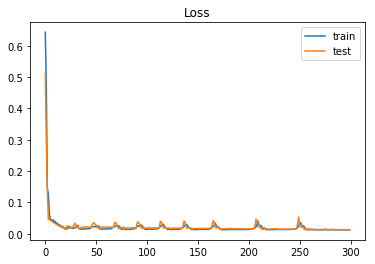

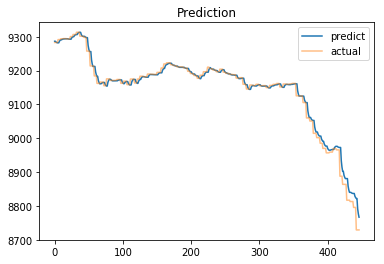

In [14]:
pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

pyplot.title("Prediction")
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [5]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

prev = 9180
threshold = 0.05

predictions = np.array([])
decisions = np.array([])

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

print predictions

[]


In [7]:
while True:
    btc = open('live_bitcoin.csv','r')
    sent = open('live_tweet.csv','r')
    bit_data = btc.readlines()
    sent_data = sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    sent_data = process_data(sent_data[len(sent_data)-5:])
    live = scaler.transform(bit_data)
    testX, testY = create_dataset(live, 2, sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    val = 100 * ((yhat_inverse[0][0] - prev)/prev)
    predictions = np.append(predictions, yhat_inverse[0][0])
    if val > threshold:
        decision = 2
        decisions = np.append(decisions, [2])
        print "Buy at: " + str(prev)
    elif val <-threshold:
        decision = 1
        decisions = np.append(decisions, [1])
        print "Sell at: " + str(prev)
    else:
        decision = 0
        decisions = np.append(decisions, [0])
        
    prev = yhat_inverse[0][0]
    input_string = "INSERT INTO live_data values ({},{},{},'{}','{}');".format(
        yhat_inverse[0][0],
        bit_data[0][0],
        sent_data[4][0],
        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
        decision)
    
    # cursor.execute(input_string)
    # conn.commit()
    

    
    time.sleep(60)

1
Sell at: 9180
1
1
1
1
1
Buy at: 9147.14
1
1
1
1
Sell at: 9152.93
1
1
1
1
1
Sell at: 9130.81
1
Sell at: 9105.69
1
1
1
1
Sell at: 9100.47
1
1
1
1
1
1
Sell at: 9091.15
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Buy at: 9064.08
1
Buy at: 9087.72
1
1
1
1
1
1
1
1
1
Buy at: 9093.47
1
1
1
1
1
1
Sell at: 9108.23
1
1
1
1
1
1
1
1
1
1
Sell at: 9091.93
1
Sell at: 9066.92
1
1
1
Buy at: 9061.44
1
1
1
1
1
1
1
1
1
1
1
Buy at: 9066.45
1
1
1
1
1
1
1
1
1
1
Buy at: 9073.02
1
Buy at: 9148.19
1
1
1
1
1
Buy at: 9164.31
1
Buy at: 9208.18
1
1
1
Buy at: 9217.12
1
Buy at: 9264.67
1
1
1
1
Buy at: 9273.81
1
1
1
1
1
1
1
1
1
1
Sell at: 9284.44
1
1
1
1
1
Buy at: 9273.58
1
1
1
1
1
1
Sell at: 9280.49
1
1
1
1
1
Sell at: 9256.22
1
1
1
1
Sell at: 9240.13
1
1
1
1
1
Sell at: 9229.45
1
1
1
1
1
1
1
1
1
1
Sell at: 9209.67
1
1
1
1
1
1
Buy at: 9204.49
1
1
1
1
1
Sell at: 9217.14
1
1
1
1
Buy at: 9208.16
1
1
1
1
1
Sell at: 9224.72
1
1
1
1
1
Sell at: 9203.14
1
1
1
1
1
Sell at: 9182.58
1
1
1
1
1
1
1
1
1
1
Sell at: 9169.32
1
1
1
1
1
Buy at:

KeyboardInterrupt: 